<a href="https://colab.research.google.com/github/greymattar/ECG_WGAN_AugmentationClassification/blob/main/Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#splitting into training and testing
import json
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import csv
from torchvision import datasets
import torchvision.transforms as transforms
from collections import Counter
import gc
import copy

from tqdm import tqdm

from ekg_class import dicts
import torch.nn as nn
from models_classifier import EcgResNet34
from sklearn.metrics import classification_report as report
from sklearn.metrics import confusion_matrix as cf_matrix
from utils import print_confusion_matrix

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

num2descr, letter2num, letter2descr, num2letter = dicts()
start_time = datetime.now()

print(("\n" + "*" * 61 + "\n\t\t\t\t\tstart time  {0:02d}:{1:02d}:{2:02.0f}\n" + "*" * 61).format(
    start_time.hour, start_time.minute, start_time.second))

drive = ""
myPath_base = os.path.join(drive, "")
path_aux = 'paper3_DM\\paper3_data'
myPath_base = os.path.join(myPath_base, '')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters etc.
dry_run = False
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
NUM_CLASSES = 9
tr_ts_ratio = 0.9     # "training set / test set" split ratio
len_ratio = 1

if dry_run:
    NUM_EPOCHS = 1
else:
    NUM_EPOCHS = 10
#classes2keep = ['/', 'A', 'L', 'N', 'R', 'f', 'j']
#classes2keep_folder = ['P', 'A', 'L', 'N', 'R', 'f', 'j']

classes2keep = ['N','/', 'A', 'L', 'R', 'f', 'j','F','a']
classes2keep_folder = ['N','P', 'A', 'L','R', 'f', 'j','F','a']


key_aug = "aug"
#key_aug = "notaug";

key_bal = 'balanced'
#key_bal = 'imbalanced';

# key_case = 'rl'
# key_case = "02"
key_case = "wgan"

len_ratio = 1                   # shorter train sets
#len_ratio = 1                  # shorter train sets
num_samples = 8000
tst_len = 1000
print('\ncase: {}, {}, {}\n'.format(key_case, key_bal, key_aug))
# num_N_samples = int(len_ratio*num_samples)

if '.' in str(len_ratio):
    len_ratio_str = str(len_ratio).replace('.', '')
else:
    len_ratio_str = str(len_ratio)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
path = "gb_dm_case_{}".format(key_case)
myPath_save = os.path.join(myPath_base, path)
os.makedirs(myPath_save, exist_ok=True)

brk = 'here'

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%   begin: From whole database select training and testing set   %%%%%%%%%%%%%%%%%%


d_set = "MIT_BIH/tesing"
myPath_save = os.path.join(myPath_base, "PycharmProjects\\paper2_gen_data\\", d_set,"classifier_wgan_gpFinal_cl_{}_{}".format(key_bal,classes2keep_folder))
os.makedirs(myPath_save, exist_ok=True)


# %%%%%%%%%%%%%%%%       begin MIT-BIH Dataset      %%%%%%%%%%%%%%%%%%%%%%%%%%%%

with open(os.path.join(myPath_base, "record_X_y_adapt_win_bef075_aft075_Normalized.json"), "r") as f:
    data = json.load(f)

stats_all_classes = Counter(np.asarray(data, dtype=object)[:, 2])

classes2gb = ['P', 'A', 'L','R', 'f', 'j','F','a']
classes2gb_count=['/', 'A', 'L','R', 'f', 'j','F','a']

class_counts = {class_label: 0 for class_label in classes2gb_count}

# create dictionary of data to be kept
vals = []
for idx in range(len(classes2keep)):
    vals.append([])

data2keep_dict = dict(zip(classes2keep, vals))
data_train_dict = dict(zip(classes2keep_folder, vals))
data_test_dict = dict(zip(classes2keep_folder, vals))
count_N = 0
for item in data:
    if item[2] == 'N'  and count_N < 10000:  # Add condition to limit 'N' data to 10000
        data2keep_dict[item[2]].append(item[1])
        count_N += 1
    elif item[2]!='N' and item[2] in classes2keep:
        data2keep_dict[item[2]].append(item[1])
        class_counts[item[2]] += 1
del data

if '/' in classes2keep:
    temp = data2keep_dict['/']
    data2keep_dict.pop('/')
    data2keep_dict['P'] = temp

    temp = class_counts['/']
    class_counts.pop('/')
    class_counts['P'] = temp



max_items_per_class= 10000
with open(os.path.join(myPath_base, "gb_together.json"), "r") as f:
    data_gb = json.load(f)




for item in data_gb:
    if item[1] in classes2gb and class_counts[item[1]] < max_items_per_class:
        data2keep_dict[item[1]].append(item[0])
        class_counts[item[1]] += 1

del data_gb



# randomly splitting the dataset into train and test sets
for key in data2keep_dict.keys():
    val_len = len(data2keep_dict[key])
    idx_train = torch.randperm(val_len)[:int(tr_ts_ratio * val_len)]
    idx_test = torch.randperm(val_len)[int(tr_ts_ratio * val_len)+1:]
    data_train_dict[key] = [data2keep_dict[key][idx] for idx in idx_train]
    data_test_dict[key] = [data2keep_dict[key][idx] for idx in idx_test]
'''
if '/' in classes2keep:
    temp = data2keep_dict['/']
    data2keep_dict.pop('/')
    data2keep_dict['P'] = temp

    temp = data_train_dict['/']
    data_train_dict.pop('/')
    data_train_dict['P'] = temp

    temp = data_test_dict['/']
    data_test_dict.pop('/')
    data_test_dict['P'] = temp

'''
# create X, y for train and test sets
X_train = []
y_train = []
for key in data_train_dict.keys():
    X_train.extend(data_train_dict[key])
    idx = [classes2keep_folder.index(key)] * len(data_train_dict[key])
    y_train.extend(idx)

X_test = []
y_test = []
for key in data_test_dict.keys():
    X_test.extend(data_test_dict[key])
    idx = [classes2keep_folder.index(key)] * len(data_test_dict[key])
    y_test.extend(idx)

y_test_stat = Counter(y_test)
y_train_stat = Counter(y_train)

print("train: {}".format(y_train_stat))
print("test: {}".format(y_test_stat))


a = 0
with open(os.path.join(myPath_save, "X_train.json"), "w") as f:
    json.dump(X_train, f)
with open(os.path.join(myPath_save, "y_train.json"), "w") as f:
    json.dump(y_train, f)
with open(os.path.join(myPath_save, "X_test.json"), "w") as f:
    json.dump(X_test, f)
with open(os.path.join(myPath_save, "y_test.json"), "w") as f:
    json.dump(y_test, f)

a=0



*************************************************************
					start time  22:44:19
*************************************************************

case: wgan, balanced, aug

train: Counter({0: 9000, 2: 9000, 3: 9000, 4: 9000, 5: 9000, 7: 9000, 8: 9000, 6: 8307, 1: 6325})
test: Counter({0: 999, 2: 999, 3: 999, 4: 999, 5: 999, 7: 999, 8: 999, 6: 922, 1: 702})


In [ ]:
pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 10.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount ('/content/gdrive')
import sys
import os
#sys.path.append('/content/gdrive/MyDrive/Augmentation-of-ECG-Training-Dataset-with-CGAN-main')
os.chdir('/content/gdrive/MyDrive/Augmentation-of-ECG-Training-Dataset-with-CGAN-main')
print(os.getcwd())

Mounted at /content/gdrive
/content/gdrive/MyDrive/Augmentation-of-ECG-Training-Dataset-with-CGAN-main


In [ ]:


trn_set = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
tst_set = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
trn_loader = DataLoader(trn_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
tst_loader = DataLoader(tst_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

brk = 'here'
# %%%%%%%%%%%%%%%%%     begin save sample plots of classes in classes2keep    %%%%%%%%%%%%%%%%%%%%
'''
for cl in classes2keep:
    fig, axes = plt.subplots(nrows=3, ncols=3)
    fig.suptitle("Class {} ({}: {}), count: {}".
                 format(classes2keep.index(cl), cl, letter2descr[cl], len(data2keep_dict[cl])))

    count = 0
    for i in range(3):
        for j in range(3):
            count += 1
            if count >= len(data2keep_dict[cl]):
                continue
            axes[i][j].plot(data2keep_dict[cl][count])
            axes[i][j].grid()
    plt.savefig(os.path.join(myPath_save, "00_sample_cl_{}.png".format(classes2keep.index(cl))))

plt.close("all")
'''
# %%%%%%%%%%%%%%%%%     end save sample plots of classes in classes2keep      %%%%%%%%%%%%%%%%%%%%


# %%%%%%%%%%%%%%%%%%%% begin:     Select and Initialize Network       %%%%%%%%%%%%%%%%%%%%%%%%%%%%
# net = net_cnn(num_classes=NUM_CLASSES).to(device)
# net = net_fc(input_size=INPUT_SIZE, num_classes=NUM_CLASSES).to(device)
net = EcgResNet34(num_classes=NUM_CLASSES).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
# %%%%%%%%%%%%%%%%%%%% end:     Select and Initialize Network       %%%%%%%%%%%%%%%%%%%%%%%%%%%%


NUM_EPOCHS = 10
# %%%%%%%%%%%%%%%%%%%%    begin:  Train Classifier       %%%%%%%%%%%%%%%%%%%%%%%%%%
for epoch in range(NUM_EPOCHS):
    for batch_idx, (inputs, labels) in enumerate(trn_loader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.reshape(inputs.shape[0], 1, -1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        scores = net(inputs)
        loss = criterion(scores.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        # running_loss += loss.item()
        if batch_idx % 1000 == 0:  # print every 200 mini-batches
            now = datetime.now()
            print('{:02d}:{:02d}:{:02d}\t\tepoch={:4d} / {:4d}\t\titer={:5d} / {:5d}\t\t\tloss: {:7.5f}'.
                  format(now.hour, now.minute, now.second, epoch, NUM_EPOCHS, batch_idx, len(trn_loader), loss))

print('\n\tFinished Training\n')
# %%%%%%%%%%%%%%%%%%%%    end  Train Network       %%%%%%%%%%%%%%%%%%%%%%%%%%%%


print('\tSaving model ...\n')

# %%%%%%%%%%%%%%%%%%%%    begin save model   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
f_name = "classifier_{}_{}_{}.pth".format(key_case, key_bal, key_aug)
PATH = os.path.join(myPath_save, f_name)
torch.save(net.state_dict(), PATH)
# %%%%%%%%%%%%%%%%%%%%    end save model     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


22:46:40		epoch=   0 /   10		iter=    0 /  4852			loss: 2.69762
22:48:44		epoch=   0 /   10		iter= 1000 /  4852			loss: 0.73200
22:50:48		epoch=   0 /   10		iter= 2000 /  4852			loss: 1.08886
22:52:53		epoch=   0 /   10		iter= 3000 /  4852			loss: 0.10722
22:54:57		epoch=   0 /   10		iter= 4000 /  4852			loss: 0.17794
22:56:43		epoch=   1 /   10		iter=    0 /  4852			loss: 0.59985
22:58:47		epoch=   1 /   10		iter= 1000 /  4852			loss: 0.12410
23:00:51		epoch=   1 /   10		iter= 2000 /  4852			loss: 0.00856
23:02:55		epoch=   1 /   10		iter= 3000 /  4852			loss: 0.41486
23:04:59		epoch=   1 /   10		iter= 4000 /  4852			loss: 0.00206
23:06:45		epoch=   2 /   10		iter=    0 /  4852			loss: 0.00378
23:08:48		epoch=   2 /   10		iter= 1000 /  4852			loss: 0.00583
23:10:52		epoch=   2 /   10		iter= 2000 /  4852			loss: 0.01440
23:12:56		epoch=   2 /   10		iter= 3000 /  4852			loss: 0.13967
23:14:59		epoch=   2 /   10		iter= 4000 /  4852			loss: 0.06787
23:16:44		epoch=   3 /   10		iter=    0 

In [ ]:
from sklearn.metrics import accuracy_score
myPath = os.path.join(myPath_base, path)
classifier_name = "classifier_{}_{}_{}.pth".format(key_case, key_bal, key_aug)
net.load_state_dict(torch.load(os.path.join(myPath_save, classifier_name)))

brk = 'here'

# %%%%%%%%%%%%%%%%%%    print Classification Report to file      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
trntst = ['tst']
for key_trntst in trntst:
    print('Preparing Classification Report: {}'.format(key_trntst))

    y_scores = []
    y_true = []
    y_pred = []
    exec('loader = {}_loader'.format(key_trntst))
    for (inputs, labels) in tqdm(loader):
        inputs = inputs.reshape(inputs.shape[0], 1, -1).to(device)
        labels = labels.to(device)
        temp = net(inputs)
        output = temp.max(dim=1)

        y_true.extend(labels.data.tolist())
        y_pred.extend(output.indices.tolist())
        y_scores.extend((F.softmax(temp, dim=1).tolist()))



    # Calculate and print the accuracy with desired precision
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_str = "{:.5f}".format(accuracy)
    print("Accuracy: {}".format(accuracy_str))



Preparing Classification Report: tst


100%|██████████| 538/538 [00:20<00:00, 26.28it/s]

Accuracy: 0.98838


In [ ]:

# %%%%%%%%%%%%%%%%%%%%    load trained classifier     %%%%%%%%%%%%%%%%%%%%%
path = "gb_dm_case_{}".format(key_case)
myPath = os.path.join(myPath_base, path)
classifier_name = "classifier_{}_{}_{}.pth".format(key_case, key_bal, key_aug)
net.load_state_dict(torch.load(os.path.join(myPath_save, classifier_name)))

brk = 'here'

# %%%%%%%%%%%%%%%%%%    print Classification Report to file      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
trntst = ['tst']
for key_trntst in trntst:
    print('Preparing Classification Report: {}'.format(key_trntst))
    path = os.path.join(myPath_save, 'classification_report_{}_{}_{}_{}.txt'.
                        format(key_trntst, key_case, key_bal, key_aug))
    with open(path, 'w') as sys.stdout:
        y_scores = []
        y_true = []
        y_pred = []
        exec('loader = {}_loader'.format(key_trntst))
        for (inputs, labels) in tqdm(loader):
            inputs = inputs.reshape(inputs.shape[0], 1, -1).to(device)
            labels = labels.to(device)
            temp = net(inputs)
            output = temp.max(dim=1)

            y_true.extend(labels.data.tolist())
            y_pred.extend(output.indices.tolist())
            y_scores.extend((F.softmax(temp, dim=1).tolist()))

        print("\n")
        print("%" * 20 + "\tClassification Report ({} Set, {}, {}, {})\t".
              format(key_trntst, key_case, key_bal, key_aug) + "%" * 20)
        print("Classes:                             {}".format(classes2keep_folder))
        print("Classifier Model:                    {}".format(net._get_name()))
        print(f"number of epochs:                    {NUM_EPOCHS}\n")
        print("Train set length:                    {}".format(len(trn_set)))
        print("Test set length:                     {}".format(len(tst_set)))
        print("Train set reduction length ratio:    {}\t".format(len_ratio_str))
        print('\nClassification Report:')
        print(report(y_true, y_pred, target_names=classes2keep_folder))
        print("\nConfusion Matrix:\n {}".format(cf_matrix(y_true, y_pred)))
        """
        precision, recall, thresholds = precision_recall_curve(y_true, np.asarray(y_scores)[:, 1])
        #here auc function won't work as it works for binary classifier
        pr_recall_auc_score = auc(recall, precision)
        print('\nPrecision-Recall AUC Score:        {:6.4f}'.format(pr_recall_auc_score))
        rocauc_score = roc_auc_score(y_true, np.asarray(y_scores)[:, 1])
        print('\nROC AUC Score:                     {:6.4f}'.format(rocauc_score))

        print_confusion_matrix(cf_matrix(y_true, y_pred), class_names=classes2keep_folder,
                               fig_name="Conf. Matrix_{}_{}_{}_{}".format(key_trntst, key_case, key_bal, key_aug))
        plt.savefig(os.path.join(myPath_save, "cfmx_{}_{}_{}_{}.png".format(key_trntst, key_case, key_bal, key_aug)))
        plt.close("all")


        plt.plot(precision, recall)
        plt.title("Precision - Recall Curve ({}, {}, {}, {})".format(key_trntst, key_case, key_bal, key_aug))
        plt.grid()
        plt.savefig(os.path.join(myPath_save, "prec_recall_curve_{}_{}_{}_{}.png".
                                 format(key_trntst, key_case, key_bal, key_aug)))
        """
        plt.close("all")
        sys.stdout = sys.__stdout__


finish_time = datetime.now()
print(("\n\n\n" + "finish time = {0:02d}:{1:02d}:{2:02.0f}").format(
    finish_time.hour, finish_time.minute, finish_time.second))

laps = finish_time - start_time
tot_sec = laps.total_seconds()
h = int(tot_sec // 3600)
m = int((tot_sec % 3600) // 60)
s = int(tot_sec - (h * 3600 + m * 60))

print("total elapsed time = {:02d}:{:2d}:{:2d}".format(h, m, s))



  0%|          | 2/538 [00:00<00:31, 16.80it/s]

Preparing Classification Report: tst


100%|██████████| 538/538 [00:18<00:00, 28.53it/s]


now testing on augmented dataset for result visualization

In [ ]:
#splitting into training and testing
import json
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import csv
from torchvision import datasets
import torchvision.transforms as transforms
from collections import Counter
import gc
import copy

from tqdm import tqdm

from ekg_class import dicts
import torch.nn as nn
from models_classifier import EcgResNet34
from sklearn.metrics import classification_report as report
from sklearn.metrics import confusion_matrix as cf_matrix
from utils import print_confusion_matrix

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

num2descr, letter2num, letter2descr, num2letter = dicts()
start_time = datetime.now()

print(("\n" + "*" * 61 + "\n\t\t\t\t\tstart time  {0:02d}:{1:02d}:{2:02.0f}\n" + "*" * 61).format(
    start_time.hour, start_time.minute, start_time.second))

drive = ""
myPath_base = os.path.join(drive, "")
path_aux = 'paper3_DM\\paper3_data'
myPath_base = os.path.join(myPath_base, '')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters etc.
dry_run = False
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
NUM_CLASSES = 9
tr_ts_ratio = 0.9     # "training set / test set" split ratio
len_ratio = 1

if dry_run:
    NUM_EPOCHS = 1
else:
    NUM_EPOCHS = 10
#classes2keep = ['/', 'A', 'L', 'N', 'R', 'f', 'j']
#classes2keep_folder = ['P', 'A', 'L', 'N', 'R', 'f', 'j']

classes2keep = ['N','/', 'A', 'L', 'R', 'f', 'j','F','a']
classes2keep_folder = ['N','P', 'A', 'L','R', 'f', 'j','F','a']


key_aug = "aug"
#key_aug = "notaug";

key_bal = 'balanced'
#key_bal = 'imbalanced';

# key_case = 'rl'
# key_case = "02"
key_case = "wgan"

len_ratio = 1                   # shorter train sets
#len_ratio = 1                  # shorter train sets
num_samples = 8000
tst_len = 1000
print('\ncase: {}, {}, {}\n'.format(key_case, key_bal, key_aug))
# num_N_samples = int(len_ratio*num_samples)

if '.' in str(len_ratio):
    len_ratio_str = str(len_ratio).replace('.', '')
else:
    len_ratio_str = str(len_ratio)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
path = "gb_dm_case_{}".format(key_case)
myPath_save = os.path.join(myPath_base, path)
os.makedirs(myPath_save, exist_ok=True)

brk = 'here'

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%   begin: From whole database select training and testing set   %%%%%%%%%%%%%%%%%%
d_set = "MIT_BIH/tesing"
myPath_classifier = os.path.join(myPath_base, "PycharmProjects\\paper2_gen_data\\", d_set,"classifier_wgan_gp_cl_{}_{}_{}".format(key_bal,classes2keep_folder,len_ratio))
os.makedirs(myPath_classifier, exist_ok=True)

myPath_save = os.path.join(myPath_base, "PycharmProjects\\paper2_gen_data\\", d_set,"classifier_wgan_gp_finalcl_{}_{}_{}".format(key_bal,classes2keep_folder,len_ratio))
os.makedirs(myPath_save, exist_ok=True)


# %%%%%%%%%%%%%%%%       begin MIT-BIH Dataset      %%%%%%%%%%%%%%%%%%%%%%%%%%%%

with open(os.path.join(myPath_base, "record_X_y_adapt_win_bef075_aft075_Normalized.json"), "r") as f:
    data = json.load(f)

stats_all_classes = Counter(np.asarray(data, dtype=object)[:, 2])

classes2gb = ['P', 'A', 'L','R', 'f', 'j','F','a']
classes2gb_count=['/', 'A', 'L','R', 'f', 'j','F','a']

class_counts = {class_label: 0 for class_label in classes2gb_count}

# create dictionary of data to be kept
vals = []
for idx in range(len(classes2keep)):
    vals.append([])

data2keep_dict = dict(zip(classes2keep, vals))
data_train_dict = dict(zip(classes2keep_folder, vals))
data_test_dict = dict(zip(classes2keep_folder, vals))
count_N = 0
for item in data:
    if item[2] == 'N'  and count_N < 10000:  # Add condition to limit 'N' data to 10000
        data2keep_dict[item[2]].append(item[1])
        count_N += 1
    elif item[2]!='N' and item[2] in classes2keep:
        data2keep_dict[item[2]].append(item[1])
        class_counts[item[2]] += 1
del data

if '/' in classes2keep:
    temp = data2keep_dict['/']
    data2keep_dict.pop('/')
    data2keep_dict['P'] = temp

    temp = class_counts['/']
    class_counts.pop('/')
    class_counts['P'] = temp



max_items_per_class= 10000
with open(os.path.join(myPath_base, "gb_together.json"), "r") as f:
    data_gb = json.load(f)




for item in data_gb:
    if item[1] in classes2gb and class_counts[item[1]] < max_items_per_class:
        data2keep_dict[item[1]].append(item[0])
        class_counts[item[1]] += 1

del data_gb



# randomly splitting the dataset into train and test sets
for key in data2keep_dict.keys():
    val_len = len(data2keep_dict[key])
    idx_train = torch.randperm(val_len)[:int(tr_ts_ratio * val_len)]
    idx_test = torch.randperm(val_len)[int(tr_ts_ratio * val_len)+1:]
    data_train_dict[key] = [data2keep_dict[key][idx] for idx in idx_train]
    data_test_dict[key] = [data2keep_dict[key][idx] for idx in idx_test]
'''
if '/' in classes2keep:
    temp = data2keep_dict['/']
    data2keep_dict.pop('/')
    data2keep_dict['P'] = temp

    temp = data_train_dict['/']
    data_train_dict.pop('/')
    data_train_dict['P'] = temp

    temp = data_test_dict['/']
    data_test_dict.pop('/')
    data_test_dict['P'] = temp

'''
# create X, y for train and test sets
X_train = []
y_train = []
for key in data_train_dict.keys():
    X_train.extend(data_train_dict[key])
    idx = [classes2keep_folder.index(key)] * len(data_train_dict[key])
    y_train.extend(idx)

X_test = []
y_test = []
for key in data_test_dict.keys():
    X_test.extend(data_test_dict[key])
    idx = [classes2keep_folder.index(key)] * len(data_test_dict[key])
    y_test.extend(idx)

y_test_stat = Counter(y_test)
y_train_stat = Counter(y_train)

print("train: {}".format(y_train_stat))
print("test: {}".format(y_test_stat))

"""
a = 0
with open(os.path.join(myPath_save, "X_train.json"), "w") as f:
    json.dump(X_train, f)
with open(os.path.join(myPath_save, "y_train.json"), "w") as f:
    json.dump(y_train, f)
with open(os.path.join(myPath_save, "X_test.json"), "w") as f:
    json.dump(X_test, f)
with open(os.path.join(myPath_save, "y_test.json"), "w") as f:
    json.dump(y_test, f)

a=0
"""


*************************************************************
					start time  22:53:57
*************************************************************

case: wgan, balanced, aug

train: Counter({0: 9000, 1: 9000, 2: 9000, 3: 9000, 4: 9000, 5: 9000, 6: 9000, 7: 9000, 8: 9000})
test: Counter({0: 999, 1: 999, 2: 999, 3: 999, 4: 999, 5: 999, 6: 999, 7: 999, 8: 999})


'\na = 0\nwith open(os.path.join(myPath_save, "X_train.json"), "w") as f:\n    json.dump(X_train, f)\nwith open(os.path.join(myPath_save, "y_train.json"), "w") as f:\n    json.dump(y_train, f)\nwith open(os.path.join(myPath_save, "X_test.json"), "w") as f:\n    json.dump(X_test, f)\nwith open(os.path.join(myPath_save, "y_test.json"), "w") as f:\n    json.dump(y_test, f)\n\na=0\n'

In [ ]:
trn_set = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
tst_set = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
trn_loader = DataLoader(trn_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
tst_loader = DataLoader(tst_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
myPath = os.path.join(myPath_base, path)
classifier_name = "classifier_{}_{}_{}.pth".format(key_case, key_bal, key_aug)
net = EcgResNet34(num_classes=NUM_CLASSES).to(device)
net.load_state_dict(torch.load(os.path.join(myPath_classifier, classifier_name)))

brk = 'here'

# %%%%%%%%%%%%%%%%%%    print Classification Report to file      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
trntst = ['tst']
for key_trntst in trntst:
    print('Preparing Classification Report: {}'.format(key_trntst))
    path = os.path.join(myPath_save, 'classification_report_testing_{}_{}_{}_{}.txt'.
                        format(key_trntst, key_case, key_bal, key_aug))
    with open(path, 'w') as sys.stdout:
        y_scores = []
        y_true = []
        y_pred = []
        exec('loader = {}_loader'.format(key_trntst))
        for (inputs, labels) in tqdm(loader):
            inputs = inputs.reshape(inputs.shape[0], 1, -1).to(device)
            labels = labels.to(device)
            temp = net(inputs)
            output = temp.max(dim=1)

            y_true.extend(labels.data.tolist())
            y_pred.extend(output.indices.tolist())
            y_scores.extend((F.softmax(temp, dim=1).tolist()))

        print("\n")
        print("%" * 20 + "\tClassification Report ({} Set, {}, {}, {})\t".
              format(key_trntst, key_case, key_bal, key_aug) + "%" * 20)
        print("Classes:                             {}".format(classes2keep_folder))
        print("Classifier Model:                    {}".format(net._get_name()))
        print(f"number of epochs:                    {NUM_EPOCHS}\n")
        print("Train set length:                    {}".format(len(trn_set)))
        print("Test set length:                     {}".format(len(tst_set)))
        print("Train set reduction length ratio:    {}\t".format(len_ratio_str))
        print('\nClassification Report:')
        print(report(y_true, y_pred, target_names=classes2keep_folder))
        print("\nConfusion Matrix:\n {}".format(cf_matrix(y_true, y_pred)))
        """
        precision, recall, thresholds = precision_recall_curve(y_true, np.asarray(y_scores)[:, 1])
        #here auc function won't work as it works for binary classifier
        pr_recall_auc_score = auc(recall, precision)
        print('\nPrecision-Recall AUC Score:        {:6.4f}'.format(pr_recall_auc_score))
        rocauc_score = roc_auc_score(y_true, np.asarray(y_scores)[:, 1])
        print('\nROC AUC Score:                     {:6.4f}'.format(rocauc_score))

        print_confusion_matrix(cf_matrix(y_true, y_pred), class_names=classes2keep_folder,
                               fig_name="Conf. Matrix_{}_{}_{}_{}".format(key_trntst, key_case, key_bal, key_aug))
        plt.savefig(os.path.join(myPath_save, "cfmx_{}_{}_{}_{}.png".format(key_trntst, key_case, key_bal, key_aug)))
        plt.close("all")


        plt.plot(precision, recall)
        plt.title("Precision - Recall Curve ({}, {}, {}, {})".format(key_trntst, key_case, key_bal, key_aug))
        plt.grid()
        plt.savefig(os.path.join(myPath_save, "prec_recall_curve_{}_{}_{}_{}.png".
                                 format(key_trntst, key_case, key_bal, key_aug)))
        """
        plt.close("all")
        sys.stdout = sys.__stdout__


finish_time = datetime.now()
print(("\n\n\n" + "finish time = {0:02d}:{1:02d}:{2:02.0f}").format(
    finish_time.hour, finish_time.minute, finish_time.second))

laps = finish_time - start_time
tot_sec = laps.total_seconds()
h = int(tot_sec // 3600)
m = int((tot_sec % 3600) // 60)
s = int(tot_sec - (h * 3600 + m * 60))

print("total elapsed time = {:02d}:{:2d}:{:2d}".format(h, m, s))



In [ ]:
from sklearn.metrics import accuracy_score
myPath = os.path.join(myPath_base, path)
classifier_name = "classifier_{}_{}_{}.pth".format(key_case, key_bal, key_aug)
net.load_state_dict(torch.load(os.path.join(myPath_classifier, classifier_name)))

brk = 'here'

# %%%%%%%%%%%%%%%%%%    print Classification Report to file      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
trntst = ['tst']
for key_trntst in trntst:
    print('Preparing Classification Report: {}'.format(key_trntst))

    y_scores = []
    y_true = []
    y_pred = []
    exec('loader = {}_loader'.format(key_trntst))
    for (inputs, labels) in tqdm(loader):
        inputs = inputs.reshape(inputs.shape[0], 1, -1).to(device)
        labels = labels.to(device)
        temp = net(inputs)
        output = temp.max(dim=1)

        y_true.extend(labels.data.tolist())
        y_pred.extend(output.indices.tolist())
        y_scores.extend((F.softmax(temp, dim=1).tolist()))



    # Calculate and print the accuracy with desired precision
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_str = "{:.5f}".format(accuracy)
    print("Accuracy: {}".format(accuracy_str))



100%|██████████| 561/561 [00:18<00:00, 30.39it/s]


In [ ]:
print("Accuracy: {}".format(accuracy_str))

100%|██████████| 561/561 [00:19<00:00, 28.96it/s]


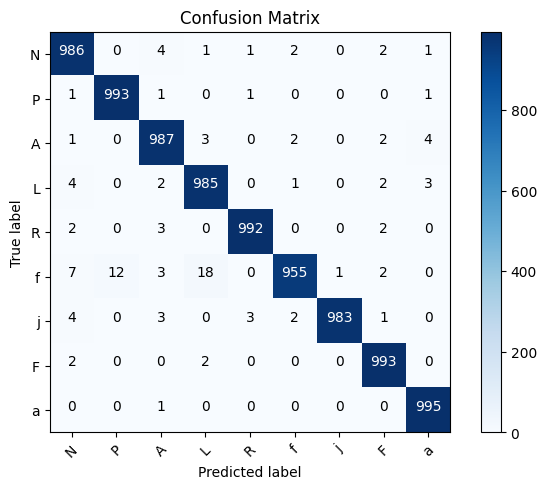

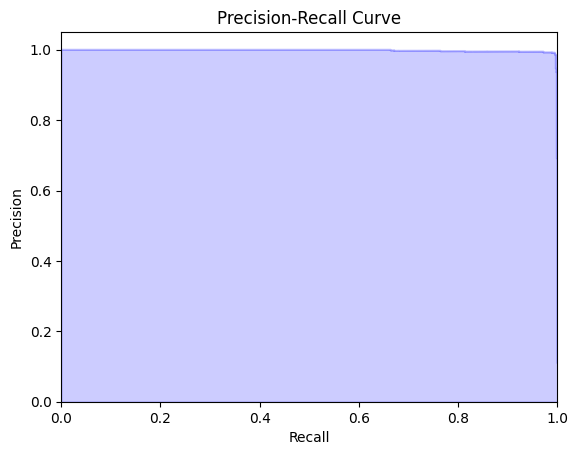

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score

myPath = os.path.join(myPath_base, path)
classifier_name = "classifier_{}_{}_{}.pth".format(key_case, key_bal, key_aug)
net.load_state_dict(torch.load(os.path.join(myPath_classifier, classifier_name)))

brk = 'here'

# %%%%%%%%%%%%%%%%%%    print Classification Report to file      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
trntst = ['tst']
for key_trntst in trntst:
    print('Preparing Classification Report: {}'.format(key_trntst))

    y_scores = []
    y_true = []
    y_pred = []
    exec('loader = {}_loader'.format(key_trntst))
    for (inputs, labels) in tqdm(loader):
        inputs = inputs.reshape(inputs.shape[0], 1, -1).to(device)
        labels = labels.to(device)
        temp = net(inputs)
        output = temp.max(dim=1)

        y_true.extend(labels.data.tolist())
        y_pred.extend(output.indices.tolist())
        y_scores.extend((F.softmax(temp, dim=1).tolist()))
# ...

# Calculate and print the accuracy with desired precision
accuracy = accuracy_score(y_true, y_pred)
accuracy_str = "{:.5f}".format(accuracy)
print("Accuracy: {}".format(accuracy_str))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = classes2keep_folder

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Calculate precision and recall
y_scores = np.array(y_scores)
precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1], pos_label=1)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')

plt.show()


In [ ]:
# accuracy = 0.98808 ... dont know why is this not printing
display( accuracy_str)

'0.98808'

In [ ]:
# Imbalanced classification

import json
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import csv
from torchvision import datasets
import torchvision.transforms as transforms
from collections import Counter
import gc
import copy

from tqdm import tqdm

from ekg_class import dicts
import torch.nn as nn
from models_classifier import EcgResNet34
from sklearn.metrics import classification_report as report
from sklearn.metrics import confusion_matrix as cf_matrix
from utils import print_confusion_matrix

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

num2descr, letter2num, letter2descr, num2letter = dicts()
start_time = datetime.now()

print(("\n" + "*" * 61 + "\n\t\t\t\t\tstart time  {0:02d}:{1:02d}:{2:02.0f}\n" + "*" * 61).format(
    start_time.hour, start_time.minute, start_time.second))

drive = ""
myPath_base = os.path.join(drive, "")
path_aux = 'paper3_DM\\paper3_data'
myPath_base = os.path.join(myPath_base, '')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters etc.
dry_run = False
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
NUM_CLASSES = 9
tr_ts_ratio = 0.9     # "training set / test set" split ratio
len_ratio = 1

if dry_run:
    NUM_EPOCHS = 1
else:
    NUM_EPOCHS = 10
#classes2keep = ['/', 'A', 'L', 'N', 'R', 'f', 'j']
#classes2keep_folder = ['P', 'A', 'L', 'N', 'R', 'f', 'j']

classes2keep = ['N','/', 'A', 'L', 'R', 'f', 'j','F','a']
classes2keep_folder = ['N','P', 'A', 'L','R', 'f', 'j','F','a']


#key_aug = "aug"
key_aug = "notaug";

#key_bal = 'balanced'
key_bal = 'imbalanced';

# key_case = 'rl'
# key_case = "02"
key_case = "wgan"

len_ratio = 0.5                   # shorter train sets
#len_ratio = 1                  # shorter train sets
num_samples = 8000
tst_len = 1000
print('\ncase: {}, {}, {}\n'.format(key_case, key_bal, key_aug))
# num_N_samples = int(len_ratio*num_samples)

if '.' in str(len_ratio):
    len_ratio_str = str(len_ratio).replace('.', '')
else:
    len_ratio_str = str(len_ratio)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
path = "gb_dm_case_{}".format(key_case)
myPath_save = os.path.join(myPath_base, path)
os.makedirs(myPath_save, exist_ok=True)

brk = 'here'

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%   begin: From whole database select training and testing set   %%%%%%%%%%%%%%%%%%


d_set = "MIT_BIH/tesing"
myPath_save = os.path.join(myPath_base, "PycharmProjects\\paper2_gen_data\\", d_set,"classifier_wgan_gp_cl_{}_{}".format(classes2keep_folder,len_ratio))
os.makedirs(myPath_save, exist_ok=True)


# %%%%%%%%%%%%%%%%       begin MIT-BIH Dataset      %%%%%%%%%%%%%%%%%%%%%%%%%%%%

with open(os.path.join(myPath_base, "record_X_y_adapt_win_bef075_aft075_Normalized.json"), "r") as f:
    data = json.load(f)

stats_all_classes = Counter(np.asarray(data, dtype=object)[:, 2])

# create dictionary of data to be kept
vals = []
for idx in range(len(classes2keep)):
    vals.append([])

data2keep_dict = dict(zip(classes2keep, vals))
data_train_dict = copy.deepcopy(data2keep_dict)
data_test_dict = copy.deepcopy(data2keep_dict)

for item in data:
    if item[2] in classes2keep:
        data2keep_dict[item[2]].append(item[1])
del data

# randomly splitting the dataset into train and test sets
for key in data2keep_dict.keys():
    val_len = len(data2keep_dict[key])
    idx_train = torch.randperm(val_len)[:int(tr_ts_ratio * val_len)]
    idx_test = torch.randperm(val_len)[int(tr_ts_ratio * val_len)+1:]
    data_train_dict[key] = [data2keep_dict[key][idx] for idx in idx_train]
    data_test_dict[key] = [data2keep_dict[key][idx] for idx in idx_test]

if '/' in classes2keep:
    temp = data2keep_dict['/']
    data2keep_dict.pop('/')
    data2keep_dict['P'] = temp

    temp = data_train_dict['/']
    data_train_dict.pop('/')
    data_train_dict['P'] = temp

    temp = data_test_dict['/']
    data_test_dict.pop('/')
    data_test_dict['P'] = temp


# create X, y for train and test sets
X_train = []
y_train = []
for key in data_train_dict.keys():
    X_train.extend(data_train_dict[key])
    idx = [classes2keep_folder.index(key)] * len(data_train_dict[key])
    y_train.extend(idx)

X_test = []
y_test = []
for key in data_test_dict.keys():
    X_test.extend(data_test_dict[key])
    idx = [classes2keep_folder.index(key)] * len(data_test_dict[key])
    y_test.extend(idx)

y_test_stat = Counter(y_test)
y_train_stat = Counter(y_train)

print("train: {}".format(y_train_stat))
print("test: {}".format(y_test_stat))

a = 0
with open(os.path.join(myPath_save, "X_train.json"), "w") as f:
    json.dump(X_train, f)
with open(os.path.join(myPath_save, "y_train.json"), "w") as f:
    json.dump(y_train, f)
with open(os.path.join(myPath_save, "X_test.json"), "w") as f:
    json.dump(X_test, f)
with open(os.path.join(myPath_save, "y_test.json"), "w") as f:
    json.dump(y_test, f)

a=0





100%|██████████| 637/637 [00:21<00:00, 29.16it/s]


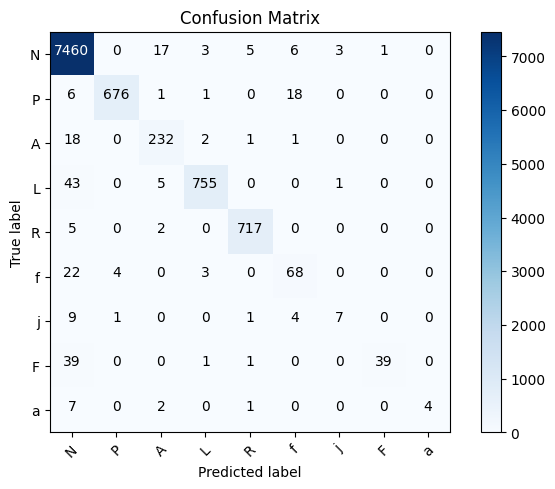

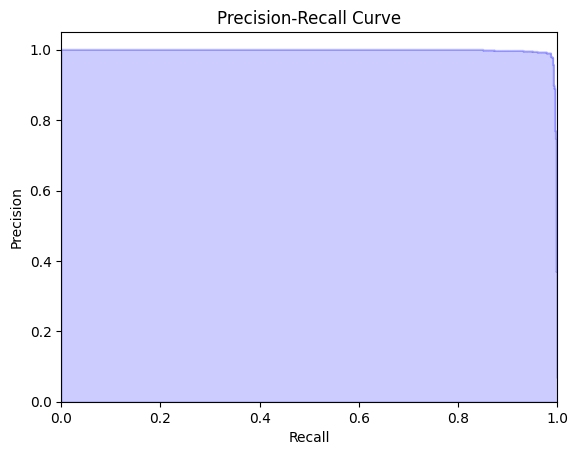

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score

trn_set = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
tst_set = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
trn_loader = DataLoader(trn_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
tst_loader = DataLoader(tst_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

myPath = os.path.join(myPath_base, path)
classifier_name = "classifier_{}_{}_{}.pth".format(key_case, key_bal, key_aug)
net.load_state_dict(torch.load(os.path.join(myPath_save, classifier_name)))

brk = 'here'

# %%%%%%%%%%%%%%%%%%    print Classification Report to file      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
trntst = ['tst']
for key_trntst in trntst:
    print('Preparing Classification Report: {}'.format(key_trntst))

    y_scores = []
    y_true = []
    y_pred = []
    exec('loader = {}_loader'.format(key_trntst))
    for (inputs, labels) in tqdm(loader):
        inputs = inputs.reshape(inputs.shape[0], 1, -1).to(device)
        labels = labels.to(device)
        temp = net(inputs)
        output = temp.max(dim=1)

        y_true.extend(labels.data.tolist())
        y_pred.extend(output.indices.tolist())
        y_scores.extend((F.softmax(temp, dim=1).tolist()))
# ...

# Calculate and print the accuracy with desired precision
accuracy2 = accuracy_score(y_true, y_pred)
accuracy_str2 = "{:.5f}".format(accuracy2)
print("Accuracy: {}".format(accuracy_str2))
#0.97704

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = classes2keep_folder

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Calculate precision and recall
y_scores2 = np.array(y_scores)
precision2, recall2, _ = precision_recall_curve(y_true, y_scores2[:, 1], pos_label=1)

# Plot precision-recall curve
plt.figure()
plt.step(recall2, precision2, color='b', alpha=0.2, where='post')
plt.fill_between(recall2, precision2, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')

plt.show()


In [ ]:
display(accuracy_str2)

'0.97704'

In [ ]:
from sklearn.metrics import precision_score

# Calculate precision for each class
precision_per_class = precision_score(y_true, y_pred, average=None)

# Print precision for each class
for i, class_label in enumerate(classes2keep_folder):
    display("Precision for class {}: {:.5f}".format(class_label, precision_per_class[i]))


'Precision for class N: 0.98130'

'Precision for class P: 0.99706'

'Precision for class A: 0.89922'

'Precision for class L: 0.99219'

'Precision for class R: 0.98204'

'Precision for class f: 0.72115'

'Precision for class j: 0.63636'

'Precision for class F: 0.91837'

'Precision for class a: 1.00000'

In [ ]:
precision_list = []
for i, class_label in enumerate(classes2keep_folder):
    precision_list.append(precision_per_class[i])

# Print precision list
display("Precision List:", precision_list)

'Precision List:'

[0.9812985644672725,
 0.9970588235294118,
 0.8992248062015504,
 0.9921875,
 0.9820441988950276,
 0.7211538461538461,
 0.6363636363636364,
 0.9183673469387755,
 1.0]

In [ ]:
precision_2=[ 0.99 , 0.98, 0.98, 0.98, 0.99 , 1.00 ,1.00, 0.99, 1.00]

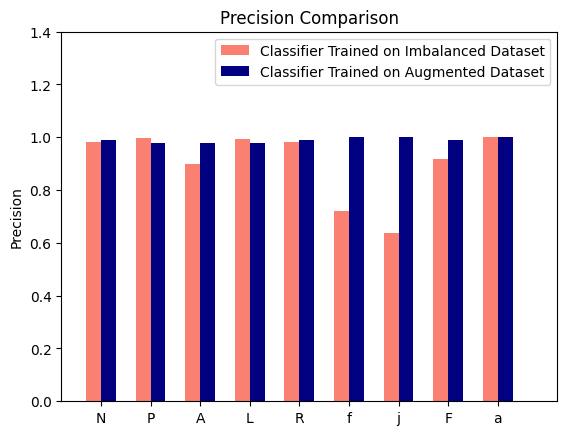

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Precision values for Classifier 1
#precision_1 = [0.85, 0.92, 0.78, 0.91, 0.82, 0.95, 0.88, 0.90, 0.83]

# Precision values for Classifier 2
#precision_2 = [0.91, 0.88, 0.95, 0.82, 0.90, 0.79, 0.92, 0.85, 0.88]

# Classes
classes = ['N', 'P', 'A', 'L', 'R', 'f', 'j', 'F', 'a']

# Prepare data for the bar graph
x = np.arange(len(classes))
width = 0.30

# Plot the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision_list, width, label='Classifier Trained on Imbalanced Dataset',color='salmon')
rects2 = ax.bar(x + width/2, precision_2, width, label='Classifier Trained on Augmented Dataset',color='navy')

ax.set_xlim(-width-.5, len(classes) - width+.5)

# Set y-limits
ax.set_ylim(0, 1.4)

# Add labels, title, and ticks to the graph
ax.set_ylabel('Precision')
ax.set_title('Precision Comparison')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
'''
# Add values above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
'''
plt.show()


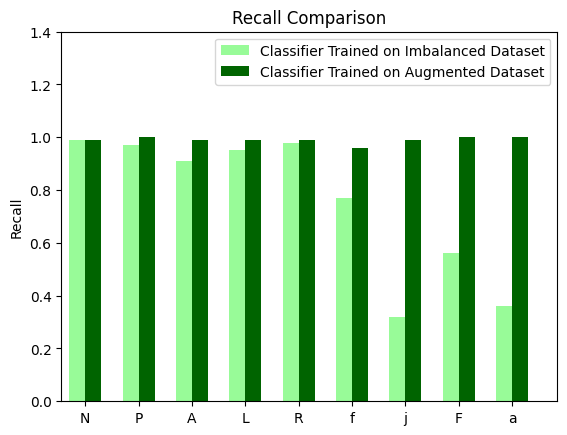

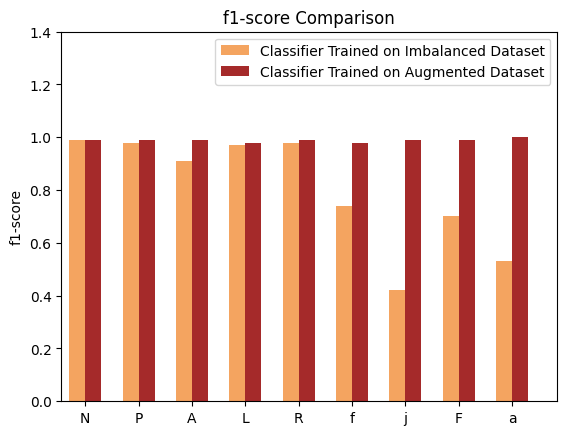

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Recall values for Classifier 1
recall_1 = [0.99, 0.97, 0.91, 0.95, 0.98, 0.77, 0.32, 0.56, 0.36]

# Recall values for Classifier 2
recall_2 = [0.99, 1.00, 0.99, 0.99, 0.99, 0.96,0.99, 1.00, 1.00]

# Classes
classes = ['N', 'P', 'A', 'L', 'R', 'f', 'j', 'F', 'a']



x = np.arange(len(classes))
width = 0.30

# Plot the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x, recall_1, width, label='Classifier Trained on Imbalanced Dataset', color='palegreen')
rects2 = ax.bar(x + width, recall_2, width, label='Classifier Trained on Augmented Dataset', color='darkgreen')

# Adjust the distance between bars of the same class
ax.set_xlim(-width, len(classes))

# Set y-limits
ax.set_ylim(0, 1.4)

# Add labels, title, and ticks to the graph
ax.set_ylabel('Recall')
ax.set_title('Recall Comparison')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(classes)
ax.legend()

plt.show()


# Recall values for Classifier 1
fscore_1 = [0.99, 0.98, 0.91, 0.97, 0.98, 0.74, 0.42, 0.70, 0.53]

# Recall values for Classifier 2
fscore_2 = [0.99, 0.99 , 0.99, 0.98, 0.99, 0.98,0.99, 0.99 , 1.00]

# Classes
classes = ['N', 'P', 'A', 'L', 'R', 'f', 'j', 'F', 'a']



x = np.arange(len(classes))
width = 0.30

# Plot the bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x, fscore_1, width, label='Classifier Trained on Imbalanced Dataset', color='sandybrown')
rects2 = ax.bar(x + width, fscore_2, width, label='Classifier Trained on Augmented Dataset', color='brown')

# Adjust the distance between bars of the same class
ax.set_xlim(-width, len(classes))

# Set y-limits
ax.set_ylim(0, 1.4)

# Add labels, title, and ticks to the graph
ax.set_ylabel('f1-score')
ax.set_title('f1-score Comparison')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(classes)
ax.legend()
plt.show()
